# How to Access GES DISC Data Using Python

### Overview

There are multiple ways to work with GES DISC data resources using Python. For example, the data can accessed using [techniques that rely on a native Python code](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). 

Still, there are several third-party libraries that can further simplify the access. In the sections below, we demonstrate downloading and streaming granules to the notebook using these libraries.

The examples will use a sample MERRA-2 granule, from the [M2T1NXSLV.5.12.4 collection](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV_5.12.4), to demonstrate data access.

### Prerequisites

<div style="background:#ADD8E6; border:1px solid #000000; padding:5px 10px; color:#000000;">
    <strong>Warning:</strong> An Earthdata Login account with the "NASA GES DISC DATA ARCHIVE" and "Hyrax in the Cloud" applications enabled are required to access GES DISC data and store "Earthdata prerequisite files". To create an Earthdata Login account, and enable these applications, please visit <a href="https://disc.gsfc.nasa.gov/earthdata-login" target="_blank">this guide</a>.
</div>

<p></p>

<div style="background:#FFFFC5; border:1px solid #000000; padding:5px 10px; color:#000000;">
    <strong>Note:</strong> Please, be very judicious when working on long data time series residing on a remote data server.<br />
    It is very likely that attempts to apply similar approaches on remote data, such as hourly data, for more than a year of data at a time, will result in a heavy load on the remote data server. This may lead to negative consequences, ranging from very slow performance that will be experienced by hundreds of other users, up to denial of service.
</div>

This notebook was written using Python 3.10, and requires these libraries and files:

- `netrc` or `edl_token` file with valid Earthdata Login credentials
   - [How to Generate Earthdata Prerequisite Files](https://disc.gsfc.nasa.gov/information/howto?title=How%20to%20Generate%20Earthdata%20Prerequisite%20Files)
- [pydap](https://github.com/pydap/pydap) (we recommend using version 3.5)
- [xarray](https://docs.xarray.dev/en/stable/) (must be >=2025.4.0)
- [netCDF4-python](https://github.com/Unidata/netcdf4-python) (we recommend using version 1.6.2)
- [earthaccess](https://earthaccess.readthedocs.io/en/latest/quick-start/)
- ***Optional:***
   - [requests](https://pypi.org/project/requests/), when using a `.edl_token` for authentication

### Optional Anaconda Environment YAML:
This notebook can be run using the ['nasa-gesdisc' YAML file](https://github.com/nasa/gesdisc-tutorials/tree/main/environments/nasa-gesdisc.yml) provided in the 'environments' subfolder. 
Please follow the instructions [here](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) to install and activate this environment.
 

### Contents
* [Search and Download Full Granule Data using `earthaccess`](#download_full_granules)

* [Search and Stream Full Granule Data using `earthaccess`](#stream_full_granules)

* [Search, Subset, and Stream Granule Data from OPeNDAP Servers](#opendap)
    * [Option 1: Use `xarray` and `pydap`](#opendap_xarray)
    * [Option 2: Use `netcdf4-python`](#opendap_netcdf4-python)
* [Search, Subset, and Stream Granule Data from THREDDS Servers Using Xarray](#thredds)

* [Search, Subset, and Stream Data from the Level 3/4 Subsetter and Regridder API](#l34rs)

### Links Used in this Notebook

There are several example links that will be used to access data from the same granule. Each link can be searched for using several tools, including [Earthdata Search](https://search.earthdata.nasa.gov/search/granules/granule-details?p=C1276812863-GES_DISC&pg[0][v]=f&pg[0][qt]=1980-01-01%2C1981&pg[0][gsk]=-start_date&g=G1277898447-GES_DISC&q=M2T1NXSLV&tl=1723660883!3!!), the [dataset landing page](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV_5.12.4) for the particular collection, or through the [Content Metadata Repository](https://cmr.earthdata.nasa.gov/virtual-directory/collections/C1276812863-GES_DISC/temporal/1980/01/01). Links can be generated programmatically using the `earthaccess` library, the [python-cmr](https://github.com/nasa/python_cmr) library, or the [Web Services API](https://disc.gsfc.nasa.gov/information/howto?keywords=dataset%).

Links used in this notebook:
- M2T1NXSLV.5.12.4 Dataset Landing Page: https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV_5.12.4
- HTTPS: https://data.gesdisc.earthdata.nasa.gov/data/MERRA2/M2T1NXSLV.5.12.4/1980/01/MERRA2_100.tavg1_2d_slv_Nx.19800101.nc4
- OPeNDAP ([?](https://disc.gsfc.nasa.gov/information/documents?title=OPeNDAP%20In%20The%20Cloud)): 
    - OPeNDAP Subsetting Page: https://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4.dmr.html
    - Example OPeNDAP URL (No Subsetting): https<nolink>://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4 (Accessing this URL in a browser will cause an error)
    - Example OPeNDAP URL (With variable subset): https<nolink>://opendap.earthdata.nasa.gov/collections/C1276812863-GES_DISC/granules/M2T1NXSLV.5.12.4%3AMERRA2_100.tavg1_2d_slv_Nx.19800101.nc4?dap4.ce=/T2M%3B/lat%3B/lon%3B/time (this is an encoded URL, intended to be accessed using wget or curl)
- THREDDS ([?](https://docs.unidata.ucar.edu/tds/4.6/adminguide/#:~:text=Overview,other%20remote%20data%20access%20protocols.)): 
    - Example THREDDS URL Subsetting Page: https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXSLV.5.12.4/M2T1NXSLV.5.12.4_Aggregation_1980.ncml.html
    - Example THREDDS URL (for `Xarray` access only): https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXSLV.5.12.4/M2T1NXSLV.5.12.4_Aggregation_1980.ncml






### Search and Download Full Granule Data using `earthaccess`  <a class="anchor" id="=download_full_granules"></a>

The `earthaccess` library can be used to search for granules and download them to your local machine, based on the collection shortname, longname, version, or DOI, gathered from the collection dataset landing page or the Content Metadata Repository. The `search_data` function will search for granules inside the specified temporal and bounding box ranges, and will return a list of URLs to be downloaded. Finally, it will download these URLs, assuming you have been authenticated using your previously-generated Earthdata prerequisite files. This method uses the `fsspec` Python library to download the granules, each of which are stored inside the `results` variable.

Please note that `earthaccess` has the ability to query OPeNDAP URLs, but not handle and execute subsetting requests to OPeNDAP servers. The URLs `earthaccess` queries will need to be passed onto `Xarray` and `Pydap`.

In [1]:
import earthaccess
import xarray as xr

# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login()

# To download multiple files, change the second temporal parameter
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    version='5.12.4',
    temporal=('1980-01-01', '1980-01-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

# Download granules to local path
downloaded_files = earthaccess.download(
    results,
    local_path='.', # Change this string to download to a different path
)

# OPTIONAL: Open granules using Xarray
ds = xr.open_mfdataset(downloaded_files)
print(ds)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:   (lon: 576, lat: 361, time: 24)
Coordinates:
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 1980-01-01T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    CLDTMP    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    DISPH     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H1000     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ...        ...
    V250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V2M    

### Search and Stream Granules Using `earthaccess` <a class="anchor" id="stream_full_granules"></a>

The `earthaccess` library has the ability to "stream" the full data of a granule, or multiple granules, to an Xarray dataset object, without having to download granule data before opening in your current notebook session.

***Please note that this will stream the full granule data including every variable to this notebook, which may take extra time and computational resources***. To access one variable at a time or perform subsetting before the data is streamed to the notebook, please access data from an OPeNDAP server, by following the steps in the next section of this notebook.

In [2]:
import earthaccess
import xarray as xr

# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login()

# We recommend only streaming a few granules at a time, as some collections can be quite large
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    version='5.12.4',
    temporal=('1980-01-01', '1980-01-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

fs = earthaccess.open(results) # Extracts URLs from the results variable

# The open_mfdataset() function must be used when opening one or multiple granules with earthaccess
ds = xr.open_mfdataset(fs) # Opens the granules and concatenates them along the time dimension
print(ds)


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:   (lon: 576, lat: 361, time: 24)
Coordinates:
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 1980-01-01T00:30:00 ... 1980-01-01T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    CLDTMP    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    DISPH     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H1000     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ...        ...
    V250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V2M    

### Search, Subset, and Stream Granule Data From OPeNDAP Servers <a class="anchor" id="opendap"></a>

Rather than having to download or stream an entire granule, you can access data from an OPeNDAP server, which will allow you to view dataset metadata and subset single or multiple varibles before its data is streamed to the current notebook session.

#### Option 1: Subset URLs Using `xarray` and `pydap` <a class="anchor" id="opendap_xarray"></a>

The `xarray` library offers a suite of various data computation, subsetting, and plotting capabilities, and can perform subsetting operations on OPeNDAP-enabled granules, as long as the user has either a `.edl_token` or a valid Earthdata username and password. This method utilizes the `pydap` engine to handle newer DAP4-protocol Cloud OPeNDAP URLs, and authenticate using either a token, or prompting for a username and password. For more information and NASA Earthdata OPeNDAP data access guides, please visit the `pydap` documentation [here](https://pydap.github.io/pydap/en/intro.html).

In the code snippet below, OPeNDAP URLs are queried and parsed from the CMR using the `earthaccess` library. Next, a DAP4 constraint expression will be appended to each URL if you wish to only access a few variables at a time. Variables and their group syntax for each OPeNDAP-enabled collection can be found by following [this guide](https://disc.gsfc.nasa.gov/information/documents?keywords=opendap&title=OPeNDAP%20In%20The%20Cloud). After, you can choose between two authentication methods: being prompted for your Earthdata username and password, or by using a `.edl_token` file. Finally, the granules are opened in `Xarray` using the `pydap` engine, and a latitude/longitude subset is made using `xarray`, further demonstrating the subsetting capabilities of OPeNDAP URLs.

**Warning:** When accessing data from OPeNDAP servers using a  `.netrc` file, rather than the authentication methods demonstrated below, you will experience errors if your `.dodsrc` prerequisite file is not generated and properly stored in addition to your `.netrc` file. Finally, the `session` parameter will need to be removed from the `open_mfdataset` command.

If you wish to save the subsetted granule locally, please use the `to_dataset` function, documented here: https://docs.xarray.dev/en/latest/generated/xarray.Dataset.to_netcdf.html


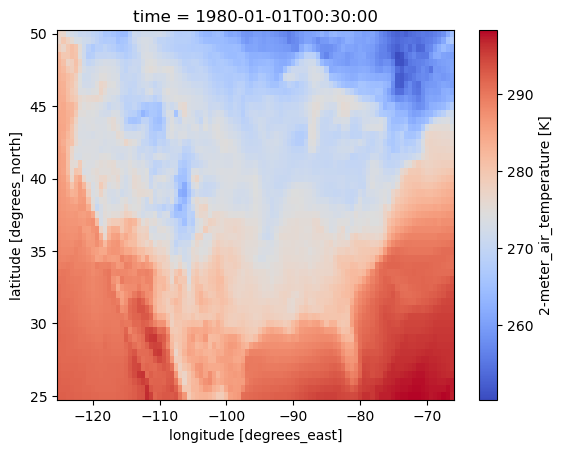

In [3]:
import xarray as xr
import os
import earthaccess
import getpass
import requests
from pydap.cas.urs import setup_session
%matplotlib inline

# Create search query for 1980-01-01 Cloud OPeNDAP URL
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    version='5.12.4',
    temporal=('1980-01-01', '1980-01-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

# Parse out URL from request, add to OPeNDAP URLs list for querying multiple granules with constraint expressions
opendap_urls = []
for item in results:
    for urls in item['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each request step
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Extract OPeNDAP URL
            url = urls['URL']

            # Subset T2M, lat, lon, and time
            # To view all variables, comment out these two lines
            ce = "?dap4.ce=/{}%3B/{}%3B/{}%3B/{}".format("T2M", "lat", "lon", "time")
            url = url + ce

            # Add URL to list
            opendap_urls.append(url)


# Delete or comment the following 12 lines to use the username/password prompt instead
# Set file path to root
token_file_path = os.path.join(os.path.expanduser("~"), ".edl_token")

# Read the token from the .edl_token file
with open(token_file_path, 'r') as token_file:
    token = token_file.read().strip()  # Ensure to strip any newlines or extra spaces

# Enter the token into the request header
my_session = requests.Session()
my_session.headers = {
    'Authorization': f'Bearer {token}'
}

# Enter your username and password without a .netrc
# Uncomment the following block to use the username/password prompt instead
'''
# Prompts for entering Earthdata login credentials
prompts = [
    'Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
    'Enter NASA Earthdata Login Password: '
]
username = input(prompts[0])
password = getpass.getpass(prompts[1])
my_session = setup_session(username, password, check_url=opendap_urls[0])
'''

try:
    # Load dataset object and metadata, but don't open the values yet
    # NOTE: When opening HDF files, the group to be accessed must be specified with the "group=" parameter. 
    #       E.g., for GPM IMERG, group="Grid" must be entered or an error will occur
    # Remove the session parameter if you are just using a .netrc file to authenticate
    ds = xr.open_mfdataset(opendap_urls, engine="pydap", session=my_session)
except OSError as e:
    print('Error', e)
    print('Please check that your .edl_token file exists and is valid, or that your username/password were entered correctly.')
    raise

# Define latitude and longitude bounds for CONUS
lat_min, lat_max = 25, 50  # Latitude bounds
lon_min, lon_max = -125, -66  # Longitude bounds

# Subset the dataset based on lat/lon bounds, which is performed server-side
ds_conus = ds.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Plot the first timestep of the 2-meter temperature variable from the subsetted dataset
ds_conus['T2M'].isel(time=0).plot(cmap='coolwarm')

#### Option 2: Search, Subset, and Stream Using `netcdf4-python` <a class="anchor" id="opendap_netcdf4-python"></a>

`netCDF4-python` is a Python library that uses the [netCDF-c](https://github.com/Unidata/netcdf-c) library to open and read netCDF4 files. It can be used to remotely access OPeNDAP-enabled netCDF4 granules. Similar to the above examples, this code block will query a MERRA-2 1980-01-01 granule, create a constraint expression subsetting `T2M`, `lat`, and `lon`, before opening with the `netcdf4-python` library.

**Warning:** When accessing data from OPeNDAP servers using `netcdf4-python`, you will experience errors if your `.dodsrc` prerequisite file is not generated and properly stored in addition to your `.netrc` file.

In [4]:
import netCDF4 as nc4
import earthaccess

# Create search query for 1980-01-01 Cloud OPeNDAP URL
results = earthaccess.search_data(
    short_name="M2T1NXSLV",
    version='5.12.4',
    temporal=('1980-01-01', '1980-01-01'), # This will stream one granule, but can be edited for a longer temporal extent
    bounding_box=(-180, 0, 180, 90)
)

# Authenticate with earthaccess
auth = earthaccess.login()

# Parse out URL from request, add to OPeNDAP URLs list for querying multiple granules
opendap_urls = []
for item in results:
    for urls in item['umm']['RelatedUrls']:  # Iterate over RelatedUrls in each request step
        if 'OPENDAP' in urls.get('Description', '').upper():  # Check if 'OPENDAP' is in the Description
            # Extract OPeNDAP URL
            url = urls['URL']
            # Add URL to list
            opendap_urls.append(url)

try:
    # Open the dataset (be sure to specify the correct dimension for aggregation)
    nc = nc4.MFDataset(opendap_urls, aggdim="time")
    # Stream the 2-meter temperature variable
    print(nc['T2M'][:])
except OSError as e:
    print('Error', e)
    print('Please check that your .dodsrc files are in their correct locations, or that your .netrc file has the correct username and password.')
    raise

[[[244.07703 244.07703 244.07703 ... 244.07703 244.07703 244.07703]
  [244.01453 244.02234 244.03015 ... 243.99109 243.9989  244.00671]
  [244.55359 244.5614  244.57703 ... 244.52234 244.53015 244.54578]
  ...
  [253.21375 253.22156 253.22937 ... 253.19226 253.20007 253.20789]
  [253.93445 253.9364  253.9403  ... 253.92468 253.92859 253.93054]
  [254.40125 254.40125 254.40125 ... 254.40125 254.40125 254.40125]]

 [[243.79819 243.79819 243.79819 ... 243.79819 243.79819 243.79819]
  [243.88412 243.89194 243.89975 ... 243.85287 243.86069 243.87631]
  [244.56381 244.57944 244.58725 ... 244.54037 244.54819 244.556  ]
  ...
  [252.97006 252.97787 252.9896  ... 252.94272 252.95053 252.96225]
  [253.75717 253.75912 253.76303 ... 253.7474  253.75131 253.75327]
  [254.31381 254.31381 254.31381 ... 254.31381 254.31381 254.31381]]

 [[243.5383  243.5383  243.5383  ... 243.5383  243.5383  243.5383 ]
  [243.75705 243.76486 243.77267 ... 243.73361 243.74142 243.74924]
  [244.61642 244.62424 244.63205

### Search, Subset, and Stream Granule Data from THREDDS Servers Using Xarray <a class="anchor" id="thredds"></a>

Datasets that include <code>.ncml</code> aggregation, like some provided through THREDDS, may be useful for quickly subsetting multiple granules into a single data array.

This operation requires a <code>.dodsrc</code> file in your root and working directories, and a <code>.netrc</code> file in your root directory. Running `auth = earthaccess.login()` will create both of these files, and can be removed after the first run, or can be removed entirely if these files are already present.

To find the THREDDS URLs, please visit the dataset landing page for your desired collection, and from the "Web Services" dropdown, select "THREDDS Data". The dataset landing page for the collection below can be found [here](https://disc.gsfc.nasa.gov/datasets/M2T1NXSLV_5.12.4/summary?keywords=M2T1NXSLV_5.12.4).

**Warning:** Please use a reasonable spatiotemporal subset when calling from THREDDS servers. Subsets that are too large will cause data access errors, or rate limiting on your IP address.

We recommend using the `xarray` library when interacting with THREDDS URLs, due to its built-in authentication and subsetting capabilities.

In [5]:
import xarray as xr
import earthaccess

# This will work if Earthdata prerequisite files have already been generated
auth = earthaccess.login()

# Subsetting a .ncml file URL:
URL = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/thredds/dodsC/MERRA2_aggregation/M2T1NXSLV.5.12.4/M2T1NXSLV.5.12.4_Aggregation_1980.ncml'

lat_slice = slice(41, 43)
lon_slice = slice(-89, -87)
time_slice = slice('1980-01-01', '1980-01-03') # Create a 3-day subset

try:
    # Access the THREDDS server ncml file, which will handle subset requests
    ds = xr.open_dataset(URL)
    # Send the subset request and stream data to the notebook using the bounding box and time slice
    ds_subset = ds.sel(lat=lat_slice,lon=lon_slice,time=time_slice)
    # Open the 2-meter temperature variable
    print(ds_subset['T2M'])
except OSError as e:
    print('Error', e)
    print('Please check that your .dodsrc files are in their correct locations, or that your .netrc file has the correct username and password.')
    raise

<xarray.DataArray 'T2M' (time: 72, lat: 5, lon: 3)>
[1080 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -88.75 -88.12 -87.5
  * lat      (lat) float64 41.0 41.5 42.0 42.5 43.0
  * time     (time) datetime64[ns] 1980-01-01T00:30:00 ... 1980-01-03T23:30:00
Attributes:
    long_name:       2-meter_air_temperature
    units:           K
    fmissing_value:  1000000000000000.0
    standard_name:   2-meter_air_temperature
    vmax:            1000000000000000.0
    vmin:            -1000000000000000.0
    valid_range:     [-1.e+15  1.e+15]
    _ChunkSizes:     [  1  91 144]


### Search, Subset, and Stream Granule Data from the Level 3/4 Subsetter and Regridder API <a class="anchor" id="l34rs"></a>

The Level 3/4 Subsetter and Regridder is a service offered by GES DISC that can subset and regrid various Level 3 and 4 collections. It has an API that can be accessed programmatically to accept the subset request, and its results will be returned to the notebook for downloading.

#### Please visit [this how-to](https://disc.gsfc.nasa.gov/information/howto?keywords=level%203&title=How%20to%20Use%20the%20Web%20Services%20API%20for%20Subsetting%20MERRA-2%20Data) for more information.